# Comparing 1-D and N-D extrapolations with the 2nd-order acoustic wave equation

In this notebook, a 'Mulder-style' immersed boundary using a 1-D extrapolation per cartesian direction is compared with an immersed boundary approach using a single N-D extrapolation.

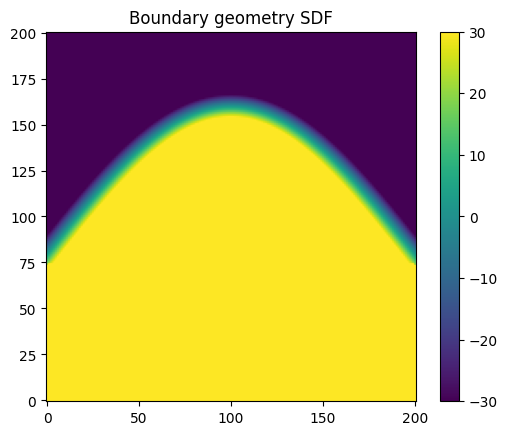

In [1]:
# Load the signed distance function for the boundary geometry
import pickle
import matplotlib.pyplot as plt

def read_sdf(surface, dims):
    """Unpickle an sdf"""
    fname = '../tests/sdfs/' + surface + '_' + str(dims) + 'd.dat'
    with open(fname, 'rb') as f:
        sdf = pickle.load(f)
    return sdf

# Load the sinusoid 2D sdf
sdf = read_sdf('hi_res_sinusoid', 2)

plt.imshow(sdf.data.T, origin='lower')
plt.title("Boundary geometry SDF")
plt.colorbar()
plt.show()

The same boundary geometry is used for both runs to compare the results of the two approaches.

In [2]:
from schism import BoundaryGeometry

bg = BoundaryGeometry(sdf)
grid = bg.grid  # Gets the grid from the signed distance function

Operator `normals` ran in 0.01 s


The same `TimeFunction` can be used for both runs, the only requirement is that the `data` attribute is reset between.

In [3]:
import devito as dv

s_o = 4
p = dv.TimeFunction(name='p', grid=grid, space_order=s_o, time_order=2)

As this notebook will use both 1-D and N-D extrapolations, separate boundary conditions are needed for each, with the former using appropriate approximations.

In [4]:
from schism import BoundaryConditions

# N-dimensional boundary conditions
bc_list_nd = [dv.Eq(p, 0),  # Zero pressure on free surface
              dv.Eq(p.dx2+p.dy2, 0),  # Zero laplacian
              dv.Eq(p.dx4 + 2*p.dx2dy2 + p.dy4, 0)]  # Zero biharmonic

# 1D boundary conditions
bc_list_1d = [dv.Eq(p, 0),  # Zero pressure on free surface
              dv.Eq(p.dx2, 0),
              dv.Eq(p.dy2, 0),  # Zero second derivative
              dv.Eq(p.dx4, 0),
              dv.Eq(p.dy4, 0)]  # Zero fourth derivative

bcs_nd = BoundaryConditions(bc_list_nd)
bcs_1d = BoundaryConditions(bc_list_1d)

First running the implementation with 1D extrapolations.

In [5]:
from schism import Boundary

boundary_1d = Boundary(bcs_1d, bg, has_1D_basis=True, strategy='reduce')

derivs = (p.dx2, p.dy2)
subs_1d = boundary_1d.substitutions(derivs)

Generating stencils for Derivative(p(t, x, y), (x, 2))
Generating stencils for Derivative(p(t, x, y), (y, 2))


Before running the models, a boundary mask to damp reflections at the edges of the domain is set up. As in previous examples, this will be a simple sponge mask.

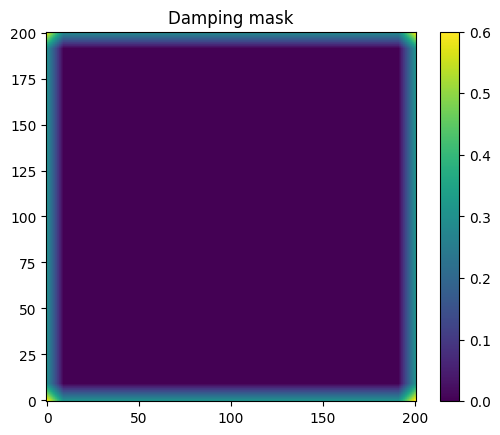

In [6]:
import numpy as np

damp = dv.Function(name='damp', grid=grid)

# Number of boundary layers
nbl = 10
taper = np.linspace(0, 0.3, nbl)

# Add the taper to the function's data
damp.data[:10] += taper[::-1, np.newaxis]
damp.data[-10:] += taper[:, np.newaxis]
damp.data[:, :10] += taper[np.newaxis, ::-1]
damp.data[:, -10:] += taper[np.newaxis, :]

plt.imshow(damp.data.T, origin='lower')
plt.title("Damping mask")
plt.colorbar()
plt.show()

Setting up the source term, a Ricker source as before.

In [7]:
from examples.seismic import TimeAxis, RickerSource

c = 1

t0 = 0.  # Simulation starts a t=0
tn = 700.  # Simulation last 0.7 seconds (700 ms)
dt = 0.5*grid.spacing[0]/c  # Time step from grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

f0 = 0.008  # Source peak frequency is 8Hz (0.008 kHz)
src = RickerSource(name='src', grid=grid, f0=f0,
                   npoint=1, time_range=time_range)

src.coordinates.data[0, 0] = 500.
src.coordinates.data[0, 1] = 500.

Snapshotting using a second `TimeFunction` and a `ConditionalDimension` will be used to sample the wavefield every 100ms.

In [8]:
snap_interval = 100  # Snapshot interval in ms
timestep_interval = round(snap_interval/dt)

time_subsampled = dv.ConditionalDimension('t_sub', parent=grid.time_dim,
                                          factor=timestep_interval)

psave = dv.TimeFunction(name='psave', grid=grid, time_order=2,
                        save=int(tn/snap_interval)+1, time_dim=time_subsampled)

eq_save = dv.Eq(psave, p)

Setting up the equation with the modified stencils:

In [9]:
eq = dv.Eq(p.forward, 2*p-p.backward+dt**2*c**2*(subs_1d[p.dx2]+subs_1d[p.dy2])+damp*p.dt)

Setting up a source injection term:

In [10]:
src_term = src.inject(field=p.forward, expr=c*src*dt**2)

Now the operator is created, remembering to include the snapshotting equation.

In [11]:
op = dv.Operator([eq] + [eq_save] + src_term)
op(time=time_range.num-1, dt=dt)

Operator `Kernel` ran in 0.04 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.03185199999999997, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.0005059999999999999, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.00010999999999999999, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

The snapshots are saved for later plotting and the wavefield is reset for a run with N-D extrapolations.

In [12]:
# Save the data for later
old_wavefield = psave.data.copy()

p.data[:] = 0

Generating new modified stencils using the N-D boundary conditions:

In [13]:
boundary_nd = Boundary(bcs_nd, bg)
subs_nd = boundary_nd.substitutions(derivs)

Generating stencils for Derivative(p(t, x, y), (x, 2))
Generating stencils for Derivative(p(t, x, y), (y, 2))


Now the equation is reformed using the updated stencils.

In [14]:
eq = dv.Eq(p.forward, 2*p-p.backward+dt**2*c**2*(subs_nd[p.dx2]+subs_nd[p.dy2])+damp*p.dt)

An operator is created and run.

In [15]:
op = dv.Operator([eq] + [eq_save] + src_term)
op(time=time_range.num-1, dt=dt)

Operator `Kernel` ran in 0.72 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.7159949999999998, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.000607, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.00017599999999999962, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

A side-by-side comparison of the two approaches at the 300ms, 400ms, 500ms, and 600ms timesteps is plotted. The boundary geometry is also shown. Plots on the left show the Mulder-style approach, whilst plots on the right show novel approach developed.

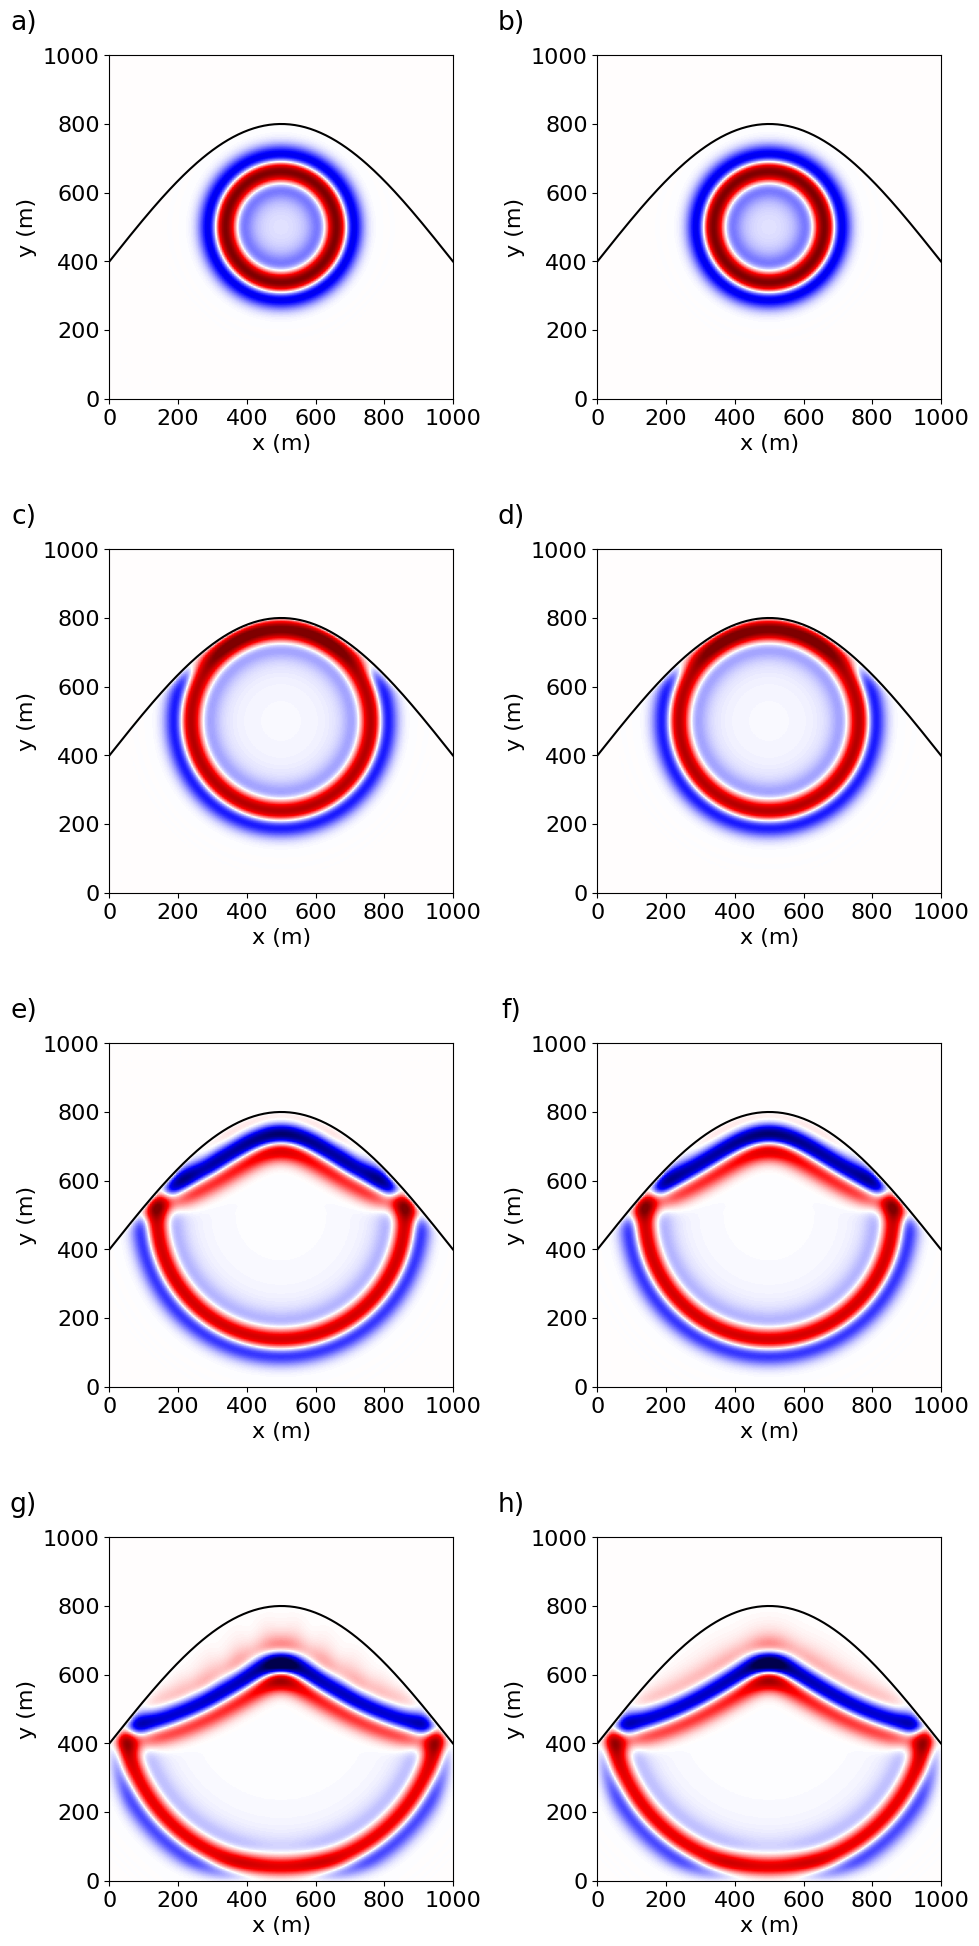

In [16]:
fig, ax = plt.subplots(4, 2, figsize=(10, 20), tight_layout=True)

def surface_func(x):
    return 400 + 400*np.sin(np.pi*x/1000)

def plot_boundary(axes, data, norm, extent, label):
    """Plot showing the immersed boundary"""
    axes.imshow(data.T/norm, origin='lower', extent=extent,
                cmap='seismic', vmin=-1, vmax=1)
    axes.set_xlabel("x (m)")
    axes.set_ylabel("y (m)")
    axes.set_title(label, x=-0.25, y=1.05)
    xvals = np.linspace(0, 1000, 201)
    yvals = surface_func(xvals)
    axes.plot(xvals, yvals, 'k')
    

extent = (0, 1000, 0, 1000)
old_norm = np.amax(np.abs(old_wavefield[3]))
norm = np.amax(np.abs(psave.data[3]))

plot_boundary(ax[0, 0], old_wavefield[3], old_norm, extent, 'a)')
plot_boundary(ax[1, 0], old_wavefield[4], old_norm, extent, 'c)')
plot_boundary(ax[2, 0], old_wavefield[5], old_norm, extent, 'e)')
plot_boundary(ax[3, 0], old_wavefield[6], old_norm, extent, 'g)')
plot_boundary(ax[0, 1], psave.data[3], norm, extent, 'b)')
plot_boundary(ax[1, 1], psave.data[4], norm, extent, 'd)')
plot_boundary(ax[2, 1], psave.data[5], norm, extent, 'f)')
plot_boundary(ax[3, 1], psave.data[6], norm, extent, 'h)')

plt.savefig("1d_nd_comparison")
plt.show()

In [17]:
assert np.isclose(np.linalg.norm(old_wavefield), 172.76538)
assert np.isclose(np.linalg.norm(psave.data), 172.6285)